# DMQC Report: WMO 4902640

## Current Status and Metadata

- Deep ARVOR float deployed September 2024 in North Pacific, still active, on cycle 51
- Trial float using text files generated by Henry Bittig to determine DOXY adjustment for DMQC

In [3]:
import sys
# travel laptop hacky solution for importing bgcArgoDMQC
sys.path.append('\\Users\\GordonC\\Documents\\projects\\bgcArgoDMQC\\')

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd

import bgcArgoDMQC as bgc

wmo = 4902636 # wmo number
# read in DMQC information from Henry Bittig
fn = f'/Users/GordonC/Documents/projects/meds-dmqc/bittig/{wmo}_IOW_Argo_inairfit_summary.txt'
meta, data, flag = bgc.io.read_bittig_textfile(fn)

history = {
    'INSTITUTION':'BI',
    'STEP':'ARSQ',
    'ACTION':'O2QC'
}

# flag is the **EXPERIMENTAL** decision made by Henry's program. Consider user driven choice here. 
adjustment = data.loc[flag]

sci_calib = {
    'COMMENT':f'',
    'EQUATION':meta['equation'],
    'COEFFICIENT':adjustment['coefficient']
}

for fn in Path(f'/Users/GordonC/Documents/data/Argo/dac/meds/{wmo}/profiles/').glob('BR*.nc'):
    prof = bgc.prof(file=fn)
    # using sprof for now - in cases where sprof PRES != DOXY_PRES (likely PROVOR floats)
    # this will not work - simple fix is to load core file and directly interpolate physical
    # variables to DOXY pressure but not done right now.
    core = bgc.prof(file=fn.as_posix().replace('BR', 'R'))

    # launch date to Argo epoch JULD
    datestr = adjustment.launch_date_juld
    launch_date_juld = bgc.unit.datestr_to_juld(datestr)

    # PPOX adjusted according to meta[equation]
    ppox_doxy_adjusted = (adjustment.SLOPE*\
        (1 + adjustment.DRIFT/100*(prof.df.JULD.reset_index(drop=True) - launch_date_juld)/365) + \
        adjustment.INCLINE_T*prof.TEMP_DOXY)*(prof.PPOX_DOXY + adjustment.OFFSET)

    # add PSAL to bgc file on its pressure grid
    prof.interp(core.PSAL, core.PRES, 'PSAL', method='nearest'), # should be adjusted, this float core in R mode

    # pO2 to umol L-1 (SCOR WG 142 code)
    doxy_adjusted_umol_L = bgc.unit.pO2_to_doxy(
        ppox_doxy_adjusted,
        prof.PSAL,
        prof.TEMP_DOXY,
        prof.PRES
    )
    # umol L-1 to umol kg-1 (density calculation)
    doxy_adjusted = bgc.unit.umol_per_L_to_umol_per_sw(
        doxy_adjusted_umol_L,
        prof.PSAL,
        prof.TEMP_DOXY,
        prof.PRES,
        lat=prof.df.LATITUDE.reset_index(drop=True),
        lon=prof.df.LONGITUDE.reset_index(drop=True)
    )

    # update fields
    prof.update_field('DOXY_ADJUSTED', doxy_adjusted)
    prof.update_field('DOXY_ADJUSTED_QC', 1)
    prof.update_field('DOXY_ADJUSTED_QC', 4, where=prof.DOXY_QC == 4)
    # export d-mode file
    prof.update_file(history, data_mode='D', sci_calib=sci_calib)



PLEASE USE BINFLAG 0 for float 4902636 according to rule 5.
Binflags that were within possible error interval: 0  2  4  6 with AICc: 26.8954      29.4077      28.1352      30.7382
Working on file BD4902636_001.nc...done
Working on file BD4902636_002.nc...done
Working on file BD4902636_003.nc...done
Working on file BD4902636_004.nc...done
Working on file BD4902636_005.nc...done
Working on file BD4902636_006.nc...done
Working on file BD4902636_007.nc...done
Working on file BD4902636_008.nc...done
Working on file BD4902636_009.nc...done
Working on file BD4902636_010.nc...done
Working on file BD4902636_011.nc...done
Working on file BD4902636_012.nc...done
Working on file BD4902636_013.nc...done
Working on file BD4902636_014.nc...done
Working on file BD4902636_015.nc...done
Working on file BD4902636_016.nc...done
Working on file BD4902636_017.nc...done
Working on file BD4902636_018.nc...done
Working on file BD4902636_019.nc...done
Working on file BD4902636_020.nc...done
Working on file BD4

Ok... D-mode files generated! Let's see if it looks any good...

(4100.0, -100.0)

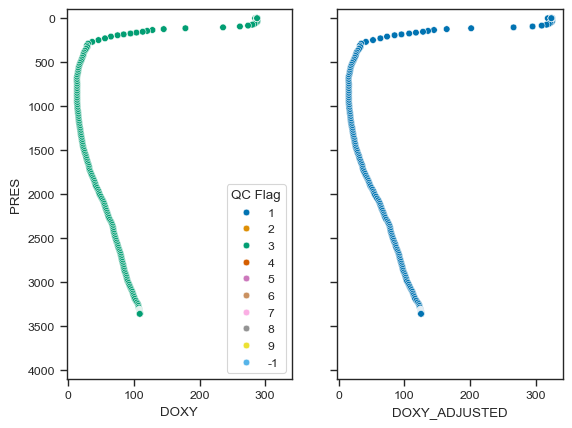

In [4]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

prof = bgc.prof(file=f'/Users/GordonC/Documents/data/Argo/dac/meds/D/{wmo}/profiles/BD{wmo}_033.nc')
prof.clean()
nc = Dataset(prof.__prof__.absolute())

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
sns.scatterplot(data=prof.df, x='DOXY', y='PRES', hue='DOXY_QC', hue_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, -1], palette='colorblind', ax=axes[0])
sns.scatterplot(data=prof.df, x='DOXY_ADJUSTED', y='PRES', hue='DOXY_ADJUSTED_QC', hue_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, -1], palette='colorblind', ax=axes[1], legend=False)

axes[0].legend(title='QC Flag')

# axes[0].set_xlim((0, 500))
axes[0].set_ylim((4100, -100))